<a href="https://colab.research.google.com/github/sujin-create/hodlhodl/blob/CoinTrading/CoinTrading/%20%EB%A7%A4%EB%8F%84%ED%83%80%EC%9D%B4%EB%B0%8D%EA%B2%B0%EA%B3%BCinsert_flow_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**autoencoding를 통한 이상값 발생시 매도에 적용(건우님제공코드 수정 및 추가)**


06-04 bitcoin_anomaly_detection의 코드를 참고하여 작성
(https://colab.research.google.com/drive/1B2NnvEs_kashPxR3CQoMRuO-rOXyhVEU?usp=sharing)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 10.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf

In [ ]:
def get_training_value(start, end,interval):
  df = yf.download("BTC-USD", start=start, end=end, interval=interval)
  df["close_chg"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
  btc = df[["close_chg"]]
  print(btc)
  btc = btc.fillna(method = "bfill")
  # Normalize and save the mean and std we get,
  # for normalizing test data.
  training_mean = btc.mean()
  training_std = btc.std()
  df_training_value = (btc - training_mean) / training_std
  print("Number of training samples:", len(df_training_value))
  return (df_training_value, training_mean,training_std)


# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def build_model(x_train):

  model = keras.Sequential(
      [
          layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
          layers.Conv1D(
              filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
          ),
          layers.Dropout(rate=0.2),
          layers.Conv1D(
              filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
          ),
          layers.Conv1DTranspose(
              filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
          ),
          layers.Dropout(rate=0.2),
          layers.Conv1DTranspose(
              filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
          ),
          layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
      ]
  )
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
  model.summary()
  return model

def fitting(model,x_train):
  history = model.fit(
      x_train,
      x_train,
      epochs=5,
      batch_size=128,
      validation_split=0.1,
      callbacks=[
          keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
      ],
  )
  return history

def get_threshold(model,x_train):

  # Get train MAE loss.
  x_train_pred = model.predict(x_train)
  train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

  plt.hist(train_mae_loss, bins=50)
  plt.xlabel("Train MAE loss")
  plt.ylabel("No of samples")
  plt.show()

  # Get reconstruction loss threshold.
  threshold = np.max(train_mae_loss)
  print("Reconstruction error threshold: ", threshold)
  return (threshold, x_train_pred)


def detect(threshold,training_mean,training_std,model):

  ticker = "BTC-USD"
  stock_data = yf.Ticker(ticker)

  hist="1mo"
  hist_data = stock_data.history(hist, interval="5m", auto_adjust=True)

  df = hist_data[["Close"]]
  #현재를 threshold와 비교해서 이상값을 탐지해야함
  df = df[-8064:]#4주

  df["close_chg"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
  btc_curr = df[["close_chg"]]
  btc_curr = btc_curr.fillna(method = "bfill")

  df_daily_jumpsup = btc_curr
  df_daily_jumpsup

  df_test_value = (df_daily_jumpsup - training_mean) / training_std
  fig, ax = plt.subplots()
  df_test_value.plot(legend=False, ax=ax)
  plt.ylim([-50, 50])
  plt.show()

  # Create sequences from test values.
  x_test = create_sequences(df_test_value.values,288)
  print("Test input shape: ", x_test.shape)

  # Get test MAE loss.
  x_test_pred = model.predict(x_test)
  test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
  test_mae_loss = test_mae_loss.reshape((-1))

  plt.hist(test_mae_loss, bins=50)
  plt.xlabel("test MAE loss")
  plt.ylabel("No of samples")
  plt.show()

  # Detect all the samples which are anomalies.
  anomalies = test_mae_loss > threshold
  print("Number of anomaly samples: ", np.sum(anomalies))
  print("Indices of anomaly samples: ", np.where(anomalies))
  print(anomalies)
  return (df_test_value,anomalies,df_daily_jumpsup)




In [ ]:
import datetime
def autoencoding(TIME_STEPS):
  print("autoencoding")
  # 하루전날까지의 14일간의 데이터를 threshold를 생성하는데 사용
  now = datetime.datetime.now()
  start = now-datetime.timedelta(days=15)
  end = now-datetime.timedelta(days=1)

  start = start.strftime('%Y-%m-%d')
  end = end.strftime('%Y-%m-%d')

  interval = "5m"
  print("training data",get_training_value(start, end,interval))
  df_training_value,training_mean,training_std = get_training_value(start, end,interval)

  x_train = create_sequences(df_training_value.values,288)
  print("Training input shape: ", x_train.shape)

  # model build
  model = build_model(x_train)
  #fitting
  history = fitting(model,x_train)
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.legend()
  plt.show()
  #treshold 결정
  threshold,x_train_pred = get_threshold(model,x_train)
  # Checking how the first sequence is learnt
  plt.plot(x_train[0])
  plt.plot(x_train_pred[0])
  plt.show()
  #detecting
  df_test_value,anomalies,df_daily_jumpsup = detect(threshold,training_mean,training_std,model)
  return (df_test_value,anomalies,df_daily_jumpsup,anomalies)



autoencoding
[*********************100%***********************]  1 of 1 completed
                           close_chg
Datetime                            
2022-05-20 00:00:00+00:00        NaN
2022-05-20 00:05:00+00:00   0.057667
2022-05-20 00:10:00+00:00  -0.106780
2022-05-20 00:15:00+00:00  -0.058799
2022-05-20 00:20:00+00:00  -0.195937
...                              ...
2022-06-02 23:35:00+00:00  -0.015072
2022-06-02 23:40:00+00:00  -0.122827
2022-06-02 23:45:00+00:00  -0.046608
2022-06-02 23:50:00+00:00  -0.143042
2022-06-02 23:55:00+00:00  -0.049650

[4032 rows x 1 columns]
Number of training samples: 4032
training data (                           close_chg
Datetime                            
2022-05-20 00:00:00+00:00   0.417258
2022-05-20 00:05:00+00:00   0.417258
2022-05-20 00:10:00+00:00  -0.777906
2022-05-20 00:15:00+00:00  -0.429188
2022-05-20 00:20:00+00:00  -1.425873
...                              ...
2022-06-02 23:35:00+00:00  -0.111390
2022-06-02 23:40:00+00:00  -0.8

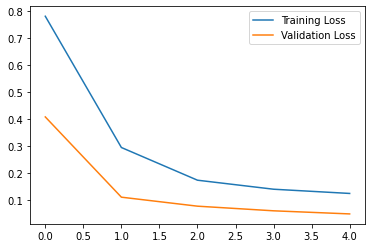

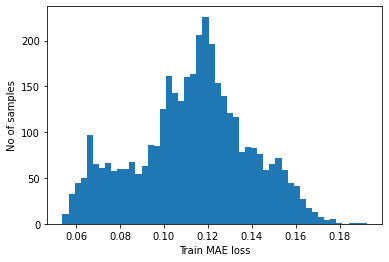

Reconstruction error threshold:  0.19231988547293963


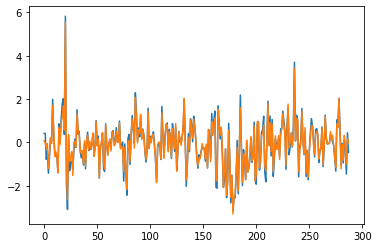

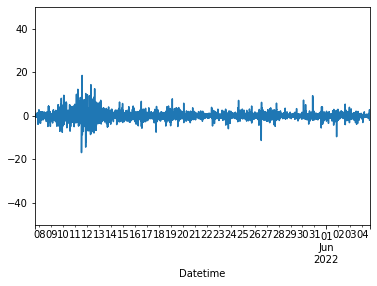

Test input shape:  (7777, 288, 1)


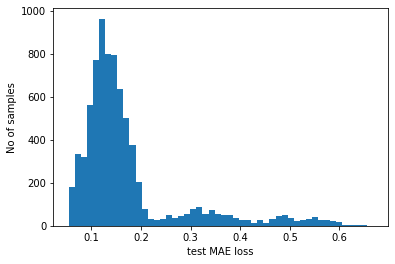

Number of anomaly samples:  1478
Indices of anomaly samples:  (array([ 302,  303,  304, ..., 3174, 3209, 3210]),)
[False False False ... False False False]
[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793

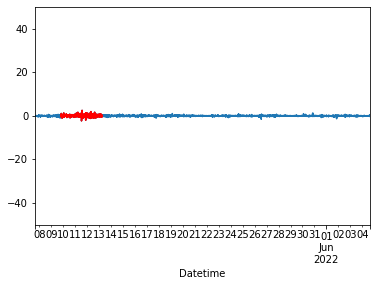

KeyboardInterrupt: ignored

In [ ]:
from time import sleep 

while(1):
  TIME_STEPS=288
  df_test_value,anomalies,df_daily_jumpsup,anomalies = autoencoding(TIME_STEPS)

  # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
  anomalous_data_indices = []
  for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
      if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
          anomalous_data_indices.append(data_idx)

  print(anomalous_data_indices)
  print(len(df_daily_jumpsup))
  df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
  fig, ax = plt.subplots()
  df_daily_jumpsup.plot(legend=False, ax=ax)
  if anomalous_data_indices:
    df_subset.plot(legend=False, ax=ax, color="r")
    print("anormaly detected!")
  plt.ylim([-50, 50])
  plt.show()

  # 아래의 조건을 만족할경우, 매도를 시작. 
  if len(df_daily_jumpsup)-1 in anomalous_data_indices : # 가장 최근의 값이 이상값이라면 아래의 코드를 수행.
    # 매도 table에 값을 넣기 => 변동성 돌파전략에서는 매도 시점이 해당 시점 5분 이내에 존재한다면 매도로 판단하는 근거가됨.
    print("이상값이 탐지되었습니다")

  sleep(300)
  print("5분후 동작")




위의 결과 error 이유 : sleep할때, 강제로 끊음. 실제로 while문이 진행되니까 끊음. 코드가 잘 돌아가는 것을 확인했으니 다음과같이함.

**Description**
**[코드설명]**
1. training 데이터는 현재날짜를 불러와서 하루전까지의 14일의 데이터를 사용.
2. training
3. testing 데이터는 현재날짜 포함 4주동안의 데이터 => 4주동안의 데이터를 코랩결과처럼 프론트단에서 보여줄예정
4. testing
5. 이상이 있는 데이터는 anomalous_data_indices 배열에 저장됨
6. 가장 최근값(5분간격의 test 데이터들중 가장 최근값)이 이상이있다면? 매도 시점으로 파악하고 매도table에 시간을 저장.
7. 5분씩 반복

**[변동성돌파전략에서 활용방법]**
1. 매도타이밍인지 체크 -> 매수타이밍인지 체크
2. 매도타이밍체크방법
매도 테이블에 저장된 시간을 읽어와서 현재 시간과 비교해서 5분이내에 저장되어있다면? 그것은 지금 매도 타이밍이라는 것. 